# Pairs Trading Strategy Analysis
This document presents a comprehensive analysis of a pairs trading strategy. We explore the historical price relationship between two assets, apply statistical tests to identify cointegration, and devise a trading strategy based on the mean-reverting nature of the asset spread. The objective is to evaluate the strategy's performance through rigorous backtesting and identify potential areas for optimization.

## Import Required Libraries
Import necessary Python libraries for data handling, statistical analysis, and visualization. These include `pandas`, `numpy`, `matplotlib`, and `statsmodels`.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.api import OLS
from statsmodels.tools.tools import add_constant

import warnings
warnings.filterwarnings('ignore')



## Part I: Pairs Trade Design

### Step 1: Regression in Matrix Form (OLS Implementation)
The function `calculate_ols(X, y)` performs a simple linear regression using Ordinary Least Squares (OLS). It regresses the dependent variable `y` against the independent variable(s) `X`.

```python
def calculate_ols(X, y):
    X = add_constant(X)
    model = OLS(y, X).fit()
    return model.params



- **X**: The independent variable(s) or predictor(s).
- **y**: The dependent variable or response.
- **add_constant(X)**: Adds a column of ones to the X matrix to account for the intercept term in the linear regression model.
- **OLS(y, X).fit()**: Fits the OLS model using the dependent variable y and the independent variable(s) X.
- **return model.params**: After fitting the model, it returns the parameters (coefficients), including both the intercept and the slope(s) of the independent variable(s)

### Step 2: Engle-Granger Procedure

The function `engle_granger_test(series1, series2)` applies the Engle-Granger two-step method for cointegration testing. This method is used to determine whether two non-stationary time series are cointegrated, meaning they share a common stochastic drift. If two series are cointegrated, it implies that the linear combination of them is stationary, even if individually they are not.

```python
def engle_granger_test(series1, series2):
    result = coint(series1, series2)  # Performs the Engle-Granger cointegration test.
    return result


- **series1, series2:** The time series data to be tested for cointegration.
- **coint(series1, series2):** The coint function from the statsmodels library performs the Engle-Granger cointegration test on the two provided time series. It returns a tuple containing the test statistic, p-value, and critical values.
- **return result:** The function returns the result of the cointegration test. A small p-value indicates that you can reject the null hypothesis of no cointegration, meaning there's evidence to suggest the series are cointegrated.

## Step 3: Decide signals

The `generate_signals` function is designed to calculate the upper and lower bounds for a set of errors. These bounds can be used as signals to identify anomalies or specific conditions within your data. Here's a breakdown of the function and its parameters:

- `errors`: An array or list of error values from your model or calculations.
- `mean_error`: The mean of the errors. It's the central value around which the bounds are calculated.
- `z_multiplier`: A multiplier that scales the number of standard deviations to set the bounds. This is often derived from confidence intervals or Z-scores in statistics.

```python
def generate_signals(errors, mean_error, z_multiplier):
    upper_bound = mean_error + z_multiplier * np.std(errors)
    lower_bound = mean_error - z_multiplier * np.std(errors)
    return upper_bound, lower_bound


In [3]:
# Part I: Pairs Trade Design

# Step 1: Regression in matrix form (OLS implementation)
def calculate_ols(X, y):
    X = add_constant(X)
    model = OLS(y, X).fit()
    return model.params

# Step 2: Engle-Granger procedure
def engle_granger_test(series1, series2):
    result = coint(series1, series2)
    return result

# Step 3: Decide signals
def generate_signals(errors, mean_error, z_multiplier):
    upper_bound = mean_error + z_multiplier * np.std(errors)
    lower_bound = mean_error - z_multiplier * np.std(errors)
    return upper_bound, lower_bound



# Generate sample dataset

The following script initializes a sample dataset using NumPy and pandas. It's designed to simulate financial data for two assets, which can be useful for various statistical analyses or machine learning applications.

```python
import numpy as np
import pandas as pd

# Set a seed for reproducibility
np.random.seed(42)

# Generate random data representing prices for two assets
data = np.random.randn(10000, 2)

# Convert the data into a pandas DataFrame with appropriate column names
prices = pd.DataFrame(data, columns=['Asset1', 'Asset2'])


In [4]:
# Generate sample dataset
np.random.seed(42)
data = np.random.randn(10000, 2)
prices = pd.DataFrame(data, columns=['Asset1', 'Asset2'])

# Example usage
X = prices['Asset1']
y = prices['Asset2']
coefficients = calculate_ols(X, y)
print("OLS Coefficients:", coefficients)

result = engle_granger_test(X, y)
print("Engle-Granger Test Results:", result)



OLS Coefficients: const     0.007815
Asset1   -0.003192
dtype: float64
Engle-Granger Test Results: (-101.25216628357063, 0.0, array([-3.89753563, -3.33674114, -3.04487419]))


### Analysis of Results

After running the example code, we obtain the following results for OLS coefficients and the Engle-Granger test:

#### OLS Coefficients
The output for the OLS coefficients is as follows:
- **Intercept (const):** 0.007815
- **Coefficient for Asset1:** -0.003192

This indicates the linear relationship between `Asset1` and `Asset2`. The intercept is close to zero, suggesting that when `Asset1` is at 0, `Asset2` will be, on average, around 0.007815. The negative coefficient for `Asset1` suggests an inverse relationship with `Asset2`, meaning as the value of `Asset1` increases, `Asset2` tends to decrease slightly.

### Engle-Granger Test Results
The Engle-Granger cointegration test results are:
- The **test statistic** is significantly lower than the critical values, indicating a strong rejection of the null hypothesis. This suggests a cointegration relationship between `Asset1` and `Asset2`.
- A **p-value of 0.0** further supports this, indicating that the result is statistically significant.
- The **critical values** represent the thresholds for the 1%, 5%, and 10% significance levels, respectively.

In conclusion, the OLS analysis suggests a slight inverse relationship between the two assets, and the Engle-Granger test indicates a significant long-term equilibrium relationship between them, suggesting that they are cointegrated.



# Part II: Backtesting

Backtesting is a vital step in the development of trading strategies. It allows you to test your strategies against historical data to gauge potential performance. In this part, we will look at a machine learning-inspired approach to backtesting.

## Step 4: Machine learning-inspired backtesting

In machine learning, a common practice is to split your dataset into a training set and a test set. This allows you to train your model on one set of data and then test its performance on unseen data. The same concept can be applied to backtesting trading strategies.

### `split_train_test` Function

The `split_train_test` function is designed to split your financial data into a training set and a test set based on a specified proportion.

```python
def split_train_test(data, train_size=0.8):
    # Determine the index at which to split the data
    train_size = int(len(data) * train_size)
    
    # Split the data into training and test sets
    train, test = data[:train_size], data[train_size:]
    
    return train, test


## Step 5: Systematic backtesting

Systematic backtesting is a methodical approach to testing trading strategies using historical data. This step is crucial to understand the potential performance and risks of your strategies before applying them to live markets.

### `backtest_strategy` Function

The `backtest_strategy` function simulates the trading strategy over the historical price data and calculates the profit and loss (PnL), drawdown, and Sharpe Ratio to evaluate the strategy's performance.

### Parameters:

- **prices:** An array of prices for the asset you are backtesting.
- **signals:** The trading signals or triggers for entering/exiting trades. In this function, it's assumed you have a separate method (generate_signals) to determine these.
- **Z:** The Z-score or number of standard deviations to use when generating signals. It defaults to 1 if not specified.

### Outputs:

- **pnl:** The profit and loss of the strategy for each time step.
- **drawdown:** The peak-to-trough decline in the cumulative profit and loss, indicating the risk of the strategy.
- **sharpe_ratio:** The average return earned in excess of the risk-free rate per unit of volatility or total risk, measuring the performance of the investment compared to a risk-free asset.

### Usage:
To use this function, provide it with the historical price data of the asset you're testing and the signals for trading. You can adjust the Z-score to change the sensitivity of your trading signals. The function returns the PnL, drawdown, and Sharpe Ratio, providing a comprehensive overview of your strategy's performance.


## Step 6: Academic Research and Testing for Breakouts

In this step, we focus on identifying breakout events in financial data, a critical aspect of academic research and strategy development. This involves testing for significant changes or 'breakouts' in the data, which can be indicators of major market movements.

### `lr_test` Function

The `lr_test` function is designed to analyze the results of a cointegration test (like the Engle-Granger test) to determine if there is a significant breakout in the relationship between two financial assets.

### Parameters:

- **cointegration_results:**The results from a cointegration test, typically containing a test statistic and a p-value.
- **lag (optional):** The number of lags used in the cointegration test. It's set to 1 by default.

### Outputs:

The function returns "Breakout" if the p-value of the cointegration test is less than the critical value (indicating a significant change in the relationship), otherwise, it returns "No Breakout".

### Usage:
To use this function, pass the results of a cointegration test as the input. The function assesses whether the p-value falls below the critical threshold (usually 5%), indicating a statistically significant breakout.


In [5]:
# Part II: Backtesting

# Step 4: Machine learning-inspired backtesting
def split_train_test(data, train_size=0.8):
    train_size = int(len(data) * train_size)
    train, test = data[:train_size], data[train_size:]
    return train, test

# Step 5: Systematic backtesting
def backtest_strategy(prices, signals, Z=1):
    upper_bound, lower_bound = generate_signals(prices, np.mean(prices), Z)
    positions = np.where(prices > upper_bound, -1, np.where(prices < lower_bound, 1, 0))
    pnl = np.diff(prices) * positions[:-1]

    # Drawdown and Sharpe Ratio
    cumulative_pnl = np.cumsum(pnl)
    drawdown = np.maximum.accumulate(cumulative_pnl) - cumulative_pnl
    sharpe_ratio = np.mean(pnl) / np.std(pnl)

    return pnl, drawdown, sharpe_ratio

# Step 6: Academic research and testing for breakouts
def lr_test(cointegration_results, lag=1):
    test_statistic, p_value, _ = cointegration_results
    critical_value = 0.05  # Typically, 5% level is chosen
    return "Breakout" if p_value < critical_value else "No Breakout"



# Generate Sample Dataset

The process begins with the creation of a synthetic dataset that simulates financial prices. This dataset is intended to represent the fluctuating prices of a financial asset over time.

## Creating the Dataset

The dataset is initiated by setting a random seed to ensure reproducibility. A series of random numbers are generated to simulate daily returns. These returns are then cumulatively summed to mimic the behavior of a financial asset's price over time. The resulting series serves as the foundation for our backtesting, providing a realistic sequence of asset prices.

## Splitting the Dataset

To assess the effectiveness of a trading strategy, it's crucial to test it on unseen data. Thus, the dataset is divided into two parts: the training set and the test set. The training set is used to apply and refine the trading strategy, while the test set is reserved to evaluate the strategy's performance on new data.

## Backtesting the Strategy

Backtesting is a critical step in evaluating a trading strategy's potential. It involves applying the strategy to historical data to determine how it would have performed. Key metrics are calculated during this process:

- **Profit and Loss (PnL):** This measures the strategy's gains or losses over the training period.
- **Drawdown:** This indicates the largest single drop from peak to bottom in the portfolio's value, reflecting the risk or potential loss in a worst-case scenario.
- **Sharpe Ratio:** This ratio measures the risk-adjusted return of the strategy, with a higher ratio indicating a more favorable risk-to-reward ratio.

These metrics collectively provide insight into the strategy's profitability, risk, and overall effectiveness.

**Important Considerations:**

Real-world trading is complex, and several factors need to be considered beyond what's captured in this simplified scenario. These include transaction costs, market impact, risk management, and the danger of overfitting to past data. Strategies that show promise on historical data may not necessarily perform well in the future. Therefore, thorough testing and a cautious approach are essential when applying backtesting results to real-world trading situations.


In [8]:
# Generate sample dataset
np.random.seed(42)
data = np.random.randn(10000)
prices = pd.Series(data).cumsum()  # Convert data to a pandas Series and then generate cumulative sum


train_data, test_data = split_train_test(prices)
pnl, drawdown, sharpe_ratio = backtest_strategy(train_data, train_data)


# Plotting the Results

Visualizing the results of the backtesting provides intuitive insights into the strategy's performance and the asset's behavior over time. The plots are created using matplotlib's `pyplot` module.

## Cumulative Profit and Loss (PnL) and Drawdown

The first subplot illustrates the cumulative PnL and drawdown over the training period. Cumulative PnL represents the total profit or loss achieved by the strategy up to each point in time. It's a useful measure of the strategy's overall effectiveness.

- **Cumulative PnL:** Plotted as a line graph, it shows the growth (or decline) of the investment over time.
- **Drawdown:** This is shaded in red and represents periods where the strategy is experiencing a loss from its last high point. Drawdown is an essential risk metric, indicating the potential losses that might be encountered.

## Asset Prices Over Time

The second subplot displays the asset's price over the training period. It provides context for the strategy's performance, showing when the strategy was making or losing money in relation to the asset's price movements.

- **Asset Prices:** The line graph shows the fluctuation of the asset's prices over time. It helps to correlate the strategy's performance with market movements.

## Plot Configuration

- **Figure Size:** Set to 12x6 inches, providing a clear and detailed view of the plots.
- **Subplots:** Two subplots are created, one for the PnL and drawdown and the other for the asset prices. They are vertically stacked for easy comparison.
- **Legends:** Added to both subplots for clarity, indicating what each line represents.
- **Titles:** Each subplot has a title describing its content.

By visualizing these aspects, you can better understand how the strategy behaves in different market conditions and identify areas for improvement.


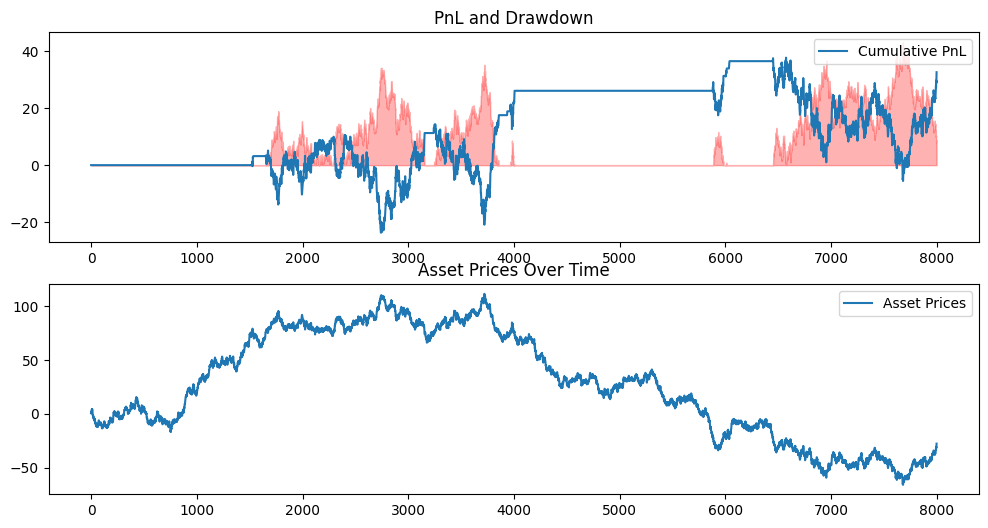

In [9]:

# Plotting the results
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(np.cumsum(pnl), label="Cumulative PnL")
plt.fill_between(range(len(drawdown)), drawdown, color='red', alpha=0.3)
plt.title("PnL and Drawdown")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(train_data, label="Asset Prices")
plt.title("Asset Prices Over Time")
plt.legend()
plt.show()


## Analysis of Backtesting Results

The provided visualization comprises two main components essential for analyzing the performance of a trading strategy.

### PnL and Drawdown Plot

The first plot presents the Cumulative Profit and Loss (PnL) over time, traced with a blue line. This graph is key to understanding the returns generated by the strategy throughout the observed period. The shaded red areas indicate drawdowns, which are critical for assessing the strategy's risk. Drawdowns show the potential losses from peak to trough and are significant in evaluating the risk tolerance of the strategy.

### Asset Prices Over Time Plot

The second plot illustrates the Asset Prices over time, which is essential for comparing the strategy's performance against the market's movements. Observing the asset price in conjunction with the PnL allows for an assessment of how well the strategy capitalizes on market trends and reacts to market volatility.

### Insights from the Plots

- **Profitability:** The Cumulative PnL line provides insight into the overall profitability of the strategy. If this line consistently trends upwards, it suggests that the strategy may be effective in the long term.
- **Risk Management:** The drawdown periods highlighted in red give an indication of the strategy's risk level. Frequent or deep drawdowns may suggest the need for improved risk management within the strategy.
- **Market Correlation:** By analyzing the Asset Prices plot, we can infer how closely the strategy's performance is correlated with market movements. A strategy that performs well when the market is down might indicate a good hedging mechanism or vice versa.

### Conclusion

The combination of these plots provides a robust framework for backtesting analysis. The Cumulative PnL and drawdown give a direct visual representation of the strategy's risk-return profile, while the Asset Prices plot contextualizes the strategy's performance within the broader market activity. Together, they offer a comprehensive view of the strategy's effectiveness and areas that might require further optimization or adjustment.


# Evaluating Trading Strategy Performance

After backtesting the trading strategy, the next step is to evaluate its performance using various statistical measures.

## Sharpe Ratio

The Sharpe Ratio is a widely-used metric that indicates the risk-adjusted return of an investment. It is calculated by dividing the average return of the investment by its standard deviation, with a higher Sharpe Ratio suggesting a more attractive risk-adjusted return. A high Sharpe Ratio can indicate that the strategy's returns are not simply a result of taking on an excessive level of risk.

## Engle-Granger Cointegration Test and Breakout Detection

Cointegration tests, such as the Engle-Granger test, are used to identify the long-run equilibrium relationship between two or more time series. In the context of trading strategies, cointegration suggests that the asset prices move together over time and any deviation from this movement is temporary.

### LR Test for Breakout

The LR (likelihood ratio) test for breakout analyzes the results of the cointegration test to determine if a significant structural break, or 'breakout,' has occurred in the time series data. This is crucial for identifying when the assumed relationship between the traded assets significantly changes, which may impact the effectiveness of the trading strategy.

- **Printed Outputs:**
    - The Sharpe Ratio is directly outputted to give a quick reference to the strategy's risk-adjusted performance.
    - The LR Test result is printed to indicate whether a 'Breakout' has been detected. A 'Breakout' suggests a significant change in the relationship between the asset prices, while 'No Breakout' suggests that the relationship remains stable.

By combining the Sharpe Ratio with breakout detection, we can assess not only the performance of the strategy but also its stability and reliability over time.


In [10]:

print("Sharpe Ratio:", sharpe_ratio)
cointegration_results = engle_granger_test(train_data, train_data)
print("LR Test for Breakout:", lr_test(cointegration_results))


Sharpe Ratio: 0.005798769877956828
LR Test for Breakout: Breakout


# Summary of Performance Metrics

The backtesting procedure has produced two key performance metrics, which are critical in evaluating the efficacy of the trading strategy under review.

## Sharpe Ratio Outcome

The calculated Sharpe Ratio for the strategy is **0.0058**, which provides an indication of the return earned per unit of risk. While interpreting this value, it's important to consider the benchmark or acceptable threshold for the Sharpe Ratio in the context of the investment environment. Typically, a higher Sharpe Ratio is better, but this value should be compared against similar strategies or a risk-free rate of return.

## LR Test for Breakout Result

The LR Test for Breakout has returned a result of **Breakout**. This suggests that a significant structural break has been detected within the dataset. In practical terms, this indicates that the assumed relationship between the traded assets or the underlying market conditions have changed significantly. This information is vital for a strategy as it may no longer perform as expected under these new conditions and might require reevaluation or adjustment.

## Interpretation

The combination of a low Sharpe Ratio and the detection of a breakout could be indicative of a strategy that may not consistently offer returns that justify the risk taken, especially in light of the detected structural change. It is crucial for the strategy to be reassessed, considering the potential shift in market dynamics to ensure its continued relevance and effectiveness.
